# Mathematical Model and Optimisation of a Axial-Flux Permanent Magnet Generator

Sources used:

[1] Radwan-Pragłowska N, Węgiel T, Borkowski D. Modeling of Axial Flux Permanent Magnet Generators. Energies. 2020; 13(21):5741. https://doi.org/10.3390/en13215741

[2] Gieras, J.F., & Shen, J.-X. (2022). Modern Permanent Magnet Electric Machines: Theory and Control (1st ed.). CRC Press. https://doi.org/10.1201/9781003103073

[3] Grauers, Anders. (1996). Design of Direct Driven Permanent Magnet Generators for Wind Turbines. 

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## General Equations

In [2]:
'''
From [1]
ψ_PM_a        :    Flux of winding 'a' generated by permanent magnets in zero current state (no load)
e_PM_a        :    Generator EMF for winding a at constant speed in zero current state (no load)
ϕ             :    Angle of rotor position with respect to reference frame
Ω             :    Angular velocity
ϑ             :    Power angle
α0            :    Angle of generator EMF
α0L           :    Angle of load voltage

'''



def RPM_2_angvel(RPM):
    return (RPM*2*np.pi/60)

def AFPMG_MODEL(t,y,RPM,L_σs,L_ss,R_stator,R_s,a_mi,ψ_ς_PM,ς):

    i=np.array(y[:3])
    psi=np.array(y[3:])
    
    a_mo = a_mi #assumption! this is for rectangle PM
    
    L = np.array([[L_σs+L_ss,0,0],[0,L_σs+L_ss,0],[0,0,L_σs+L_ss]])

    ψ_PM_1 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_2 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_3 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM = np.array([ψ_PM_1,ψ_PM_2,ψ_PM_3])
    
    dψ_PM_1_dt = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi))) * RPM_2_angvel(RPM)
    dψ_PM_2_dt = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi))) * RPM_2_angvel(RPM)
    dψ_PM_3_dt = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi))) * RPM_2_angvel(RPM)
    dψ_PM_dt = np.array([dψ_PM_1_dt,dψ_PM_2_dt,dψ_PM_3_dt])
    
    dψ_PM_1_dpsi = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
    dψ_PM_2_dpsi = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
    dψ_PM_3_dpsi = np.sum(-1j * ς * ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
    dψ_PM_dpsi = np.array([dψ_PM_1_dpsi,dψ_PM_2_dpsi,dψ_PM_3_dpsi])
    
    E_G_ph = p * RPM_2_angvel(RPM) * np.sqrt(2) * ψ_PM
    # Check if this is correct;
    # di_dt = np.linalg.solve(L, E_G_ph * np.exp(1j * ((a_mo+a_mi) / 2)/(4 * R_s))- np.dot(R_stator,i) - dψ_PM_dt)
    di_dt = np.linalg.solve(L, E_G_ph - np.dot(R_stator,i) - dψ_PM_dt)
    dpsi_dt= np.array([RPM_2_angvel(RPM)])
    
    return np.concatenate([di_dt,dpsi_dt])

## Model of Coreless Generator with Simple Magnets

In [3]:
'''
From [1]
Constants
µ_0            :    Free spaece permeablilty 
µ_rm           :    Air magnetic permeability
λ_0            :    Constant component for distribution of unit permeability function, =µ_0/(l_δ+2*l'm)

Geometry
r_s            :    0.5*(R_o+R_i)
R_o            :    Outer radius of magnet
R_i            :    Inner radius of magnet
beta           :    0.5*width of magnet at a specific radius. Here, this paper assumes simple PM: beta = (a_mo+a_mi)/(4*r)
l_c            :    =R0-Ri is the magnet length. Note that it has been found that the best is Ri=0.6*Ro
l_c_p          :    l′c approx = Ro-Ri 
l_m            :    height of magnet
l_m_p          :    l'm=lm/µ_rm
l_δ            :    distance between two magnets on both rotors (see Fig 3)

Rotor
Hm             :    magnetic field intensity, ampere turbs per meter unit
B_m            :    Permanent magnet flux density =B_r + mu_0*µ_rm*Hm
a_m            :    =0.5*(a_mo+a_mi), average
a_mo           :    outer radius magnet width
a_mi           :    inner radius magnet width
p              :    Number of magnet/2 (number of pole pairs)

Stator
a_c            :    Distance between winding, average (fig 6)
a_co           :    Distance between widing at outer radius
a_ci           :    Distance between winding at inner radius
a_sc           :    Thickness of winding (fig 6)

Equation
k_e            :    Correction factor for flux weakining at inner and outer magnet edges
B_r_AV         :    Average value of axial component of magnetic flux-density distribution from PM in the middle of the air gap Bm along the coordinate r
B_θ_AV         :    Average value of axial component of magnetic flux-density distribution from PM in the middle of the air gap Bm according to radial coordinate

B_edge         :    value of magnetic flux-density at edge of magnets
B_max          :    maximmum flux-density value
B_ς_PM         :    Foureir coefficients given in euqation (15)
ς              :    is a subset of: Q = {...,-5p,-3p,-p,3p,5p,...}

ψ_ς_PM         :    Coefficients of flux linkages induced by PM
W_ς_S          :    =w_s*k_s_v/|v|
w_s            :    total numbner of turns of stator winding
k_s_v          :    Winding factor for ςth harmnoic
'''


def CorelessGenSimpleMagnet(pmgeovar,statorvar,rotorvar,constants,ς):
    R_o,R_i,l_m,a_mi=pmgeovar
    p,l_δ=rotorvar
    w_s,a_co,a_ci,a_sc=statorvar
    µ_0,µ_rm,B_r=constants
    
    #Relations with the assumption that: simple magnet, coreless stator and averaged PM and stator geometry values
    l_c = R_o-R_i
    l_c_p = l_c
    r_s = 0.5*(R_o+R_i)
    a_c=0.5*(a_co+a_ci)
    a_mo = a_mi #assumption! this is for rectangle PM
    
    #Equation
    B_ς_PM=lambda r,ς : ((2*B_r*p)/(np.pi*ς))*np.sin(ς*((a_mo+a_mi)/2)/(4*r))*(2*np.sinh(ς*l_m/r)*np.cosh(ς*(2*l_m+l_δ)/(2*r)))/(µ_rm*np.sinh(ς*(2*l_m+l_δ)/r))
    B_max=np.sum(B_ς_PM(r_s,ς))
    B_edge=0.5*B_max

    B_r_AV = B_max*((l_c - (l_m + l_δ)) / l_c) + B_edge * ((l_m + l_δ) / l_c) + (B_max - B_edge) * (2 / np.pi) * ((l_m + l_δ) / l_c)
    B_θ_AV = np.sum(B_ς_PM(r_s,ς)*np.sin(ς*(((a_mo+a_mi)/2)/(4*r_s)))/(ς*((a_mo+a_mi)/2)/(4*r_s)))

    k_e = B_r_AV/B_θ_AV
    
    k_s_v = lambda r,v : np.sin(abs(v)*a_c/(2*r))*(np.sin(abs(v)*a_sc/(2*r))/(abs(v)*a_sc/(2*r)))
    W_ς_S = w_s*k_s_v(r_s,abs(ς))/abs(ς)
    ψ_ς_PM = 2*k_e*B_ς_PM(r_s,ς)*W_ς_S*r_s*l_c
    
    l_m_p = l_m/µ_rm
    λ_0 = µ_0/(l_δ+2*l_m_p)
    W_v_S=w_s*k_s_v(r_s,p)/abs(p)
    L_ss = (2/np.pi)*(W_v_S**2)*r_s*l_c_p*λ_0
    T_cog = 0
    
    L_σs=2*µ_0*(w_s**2)*(l_c_p+(a_c-a_sc))*0.3/p_s

    return ψ_ς_PM,L_ss,L_σs,T_cog



## Model of  Generator with Stator Core

## All variables


In [4]:
'''
From [1]
Constants
µ_0            :    Free spaece permeablilty 
µ_rm           :    Air magnetic permeability
λ_0            :    Constant component for distribution of unit permeability function, =µ_0/(l_δ+2*l'm)

Geometry
r_s            :    0.5*(R_o+R_i)
R_o            :    Outer radius of magnet
R_i            :    Inner radius of magnet
beta           :    0.5*width of magnet at a specific radius. Here, this paper assumes simple PM: beta = (a_mo+a_mi)/(4*r)
l_c            :    =R0-Ri is the magnet length. Note that it has been found that the best is Ri=0.6*Ro
l_c_p          :    l′c approx = Ro-Ri 
l_m            :    height of magnet
l_m_p          :    l'm=lm/µ_rm
l_δ            :    distance between two magnets on both rotors (see Fig 3)

Rotor
Hm             :    magnetic field intensity, ampere turbs per meter unit
B_m            :    Permanent magnet flux density =B_r + mu_0*µ_rm*Hm
a_m            :    =0.5*(a_mo+a_mi), average
a_mo           :    outer radius magnet width
a_mi           :    inner radius magnet width
p              :    Number of magnet/2 (number of pole pairs)
p_s            :    Number of coils per phase

Stator
a_c            :    Distance between winding, average (fig 6)
a_co           :    Distance between widing at outer radius
a_ci           :    Distance between winding at inner radius
a_sc           :    Thickness of winding (fig 6)
w_s            :    total numbner of turns of stator winding

K&J Magnetics Demagnetization Curves for Grade N35 Neodymium Magnets

Temperature: 20°C
H (kOe), B (kGauss)
-12.61, 0.00
-12.47, 9.27
-12.19, 10.30
-11.74, 11.01
-10.88, 11.41
-9.61, 11.68
0.00, 12.10
-8.90, 2.82
-9.71, 1.96
-10.32, 1.30
-10.80, 0.75
-11.28, 0.17
-11.42, 0.00

'''

#Constants
µ_0 = 4*np.pi*0.0000001
µ_rm = 1.07
Hm = 899000
#B_m = 2.82
#B_r = B_m-µ_0*µ_rm*Hm
B_r = 1.2 #Reamenance flux density

#PM Geometry
R_o = 0.310
R_i = 0.270
l_m = 0.010
a_mi = 0.018

#Stator properties
w_s = 980.0
a_co = 0.050
a_ci = 0.050
a_sc = 0.030
R_stator=2

#Rotor properties
p=14
p_s=p/2
l_δ = 0.026

'''
Design variable groups
#PM Geometry
#Stator properties
#Rotor properties
'''

Constants=[µ_0,µ_rm,B_r]
PMGeoVars=[R_o,R_i,l_m,a_mi]
StatorVars=[w_s,a_co,a_ci,a_sc]
RotorVars=[p,l_δ]

# Design Variables=p,R_o,R_i,

## Coreless, Simple Magnet


### Instantaneous values

C:\Users\Kai Wen Lee\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


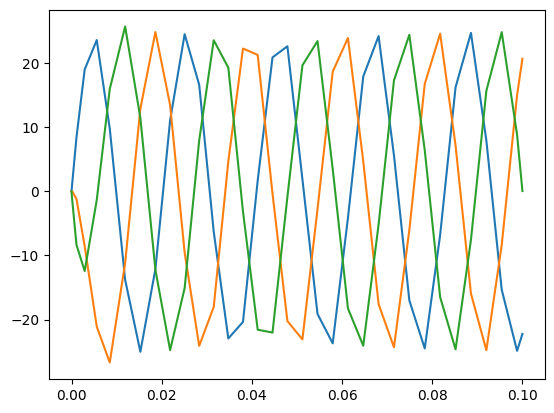

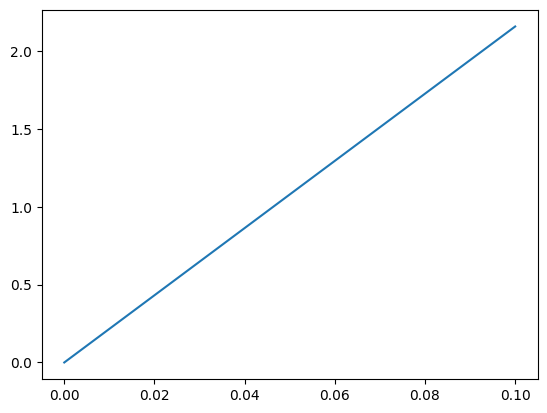

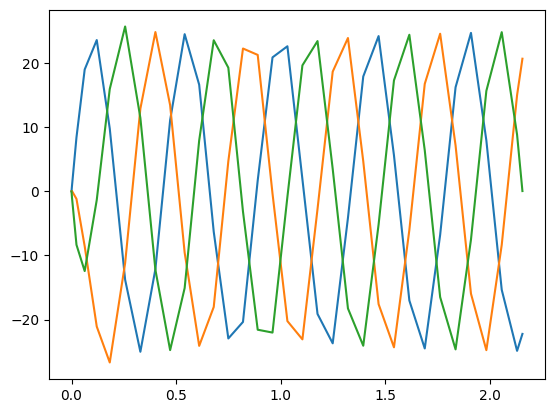

In [5]:
ς = np.array([i * p for i in range(-5, 6) if i != 0 and i % 2 != 0])
ψ_ς_PM, L_ss, L_σs, T_cog = CorelessGenSimpleMagnet(PMGeoVars, StatorVars, RotorVars, Constants,ς)
y0=np.array([0,0,0,0],dtype=np.complex128)

RPM=206

args_=(RPM,L_σs,L_ss,R_stator,(R_o-R_i)/2,a_mi,ψ_ς_PM,ς)
t=solve_ivp(AFPMG_MODEL,[0.0,0.1],y0,args=args_).t
sol=solve_ivp(AFPMG_MODEL,[0.0,0.1],y0,args=args_).y

for i in range(3):
    plt.plot(t,sol[i])

plt.show()

plt.plot(t,sol[3])
plt.show()

for i in range(3):
    plt.plot(sol[3],sol[i])
plt.show()

### Simplified Monoharmonic AFPMG Model in Steady State with Simple Load

In [7]:
'''
From [1]
E_G_ph        :    EMF per phase of generator
e_PM_a        :    Generator EMF for winding a at constant speed in zero current state (no load)
ϕ             :    Angle of rotor position with respect to reference frame
Ω             :    Angular velocity
ϑ             :    Power angle
α0            :    Angle of generator EMF
α0L           :    Angle of load voltage

X_S           :    Generator reactance
R_S           :    Generator resistance
X_L           :    Load reactance

R_L           :    Load resistance
L_L           :    Load inductance

I_G           :    Generator phase current

'''

psi_arr=np.linspace(0,2*np.pi,100)

X_S = p * RPM_2_angvel(RPM) * (L_σs+L_ss)
R_S = R_stator

L_L = 0
X_L =  p * RPM_2_angvel(RPM) * L_L
R_L = 40


X_SL = X_L+X_S
R_SL = R_S + R_L

α0 = np.arctan(X_SL/R_SL)
α0L = np.arctan(X_L/R_L)
ϑ = α0 - α0L

res=[]
for psi in psi_arr:
    ψ_PM_1 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((1 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_2 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((2 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM_3 = np.sum(ψ_ς_PM * np.exp(1j * ς * ((3 - 1) * 4 * np.pi / (3 * p) - psi)))
    ψ_PM = np.array([ψ_PM_1,ψ_PM_2,ψ_PM_3])
    E_G_ph = p*RPM_2_angvel(RPM)*np.sqrt(2)*ψ_PM
    e_j_β0 = np.exp(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2))
    e_j_ϑ_β0 = np.exp(ϑ+(1j * ((a_mi+a_mi) / 2) / (4 * (R_o-R_i) / 2)))
    e_j_0 = np.exp(ϑ * 1j)
    
    I_G = (-E_G_ph*e_j_0)/(R_SL+1j*X_SL)
    T_em_AV = (3*(E_G_ph**2)*R_SL)/(RPM_2_angvel(RPM)*(R_SL**2+X_SL**2))
    P_el = 3*R_L*abs(I_G**2)
    
    res.append([E_G_ph,I_G,T_em_AV,P_el])
    
for sublist in res:
    print(sublist[3])

[222.3193036  64.3911456  64.3911456]
[ 99.3766528  217.78237244  33.64645009]
[ 11.27989333 134.50965242 204.37627784]
[182.7620935    0.6139263  166.34385443]
[192.32795726 154.18994132   3.32427538]
[ 18.97957171 210.77212289 120.67831032]
[ 85.14517546  45.16229112 220.68218944]
[221.59117048  51.34513909  78.11477447]
[113.62393034 213.45850709  23.48025899]
[  5.47131852 147.80274281 196.66062185]
[1.72074294e+02 6.82887269e-02 1.77551921e+02]
[200.6796513  141.23535839   8.12887229]
[ 28.37900207 215.79671592 106.51366146]
[ 71.18544695  57.76621353 222.1371915 ]
[219.41184012  39.25163741  92.24331057]
[127.64900671 207.74271968  14.90437437]
[  1.70162512 160.37660013 187.69147256]
[160.37660013   1.70162512 187.69147256]
[207.74271968 127.64900671  14.90437437]
[ 39.25163741 219.41184012  92.24331057]
[ 57.76621353  71.18544695 222.1371915 ]
[215.79671592  28.37900207 106.51366146]
[141.23535839 200.6796513    8.12887229]
[6.82887269e-02 1.72074294e+02 1.77551921e+02]
[147.80